In [ ]:
using Plots
include("TDCM_modelling.jl")

In [1]:
include("TDCM_full_transition.jl")

update_inverse_gamma_distribution (generic function with 1 method)

In [2]:
using RCall

# R"""
# load("TDCM_data_three_skill_1000_per_group.RData")
# """
R"""
load("TDCM_Multilevel_data_three_skills.RData")
"""
# R"""
# load("TDCM_Multilevel_data.RData")
# """
TDCM_data = @rget data
Y = Array{Int, 3}(TDCM_data[:Y])
Q = convert(Matrix{Int64}, TDCM_data[:Q_matrix])
U = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_group])
for skill in TDCM_data[:X_ind]
    for time in 1:length(skill)
        if skill[time] isa Vector{<: Number}
            skill[time] = reshape(skill[time], :, 1)
        end
    end
end
X = Vector{Vector{Matrix{Float64}}}(TDCM_data[:X_ind])
group = Vector{Int64}(TDCM_data[:group])
obs = TDCMObs(Y, Q, U, X, group)

# R"""
# load("TDCM_multilevel_J50_data.RData")
# """
# TDCM_J50_data = @rget data_large_questions
# Y = Array{Int, 3}(TDCM_J50_data[:Y])
# Q = convert(Matrix{Int64}, TDCM_J50_data[:Q_matrix])
# U = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_group])
# for skill in TDCM_J50_data[:X_ind]
#     for time in 1:length(skill)
#         if skill[time] isa Vector{<: Number}
#             skill[time] = reshape(skill[time], :, 1)
#         end
#     end
# end
# X = Vector{Vector{Matrix{Float64}}}(TDCM_J50_data[:X_ind])
# group = Vector{Int64}(TDCM_J50_data[:group])
# obs_J50 = TDCMObs(Y, Q, U, X, group)
;

In [3]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2)
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2)
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2)
            for z in 1:2
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

M = 100
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)

# J50 = size(obs_J50.Y, 3)
# mu_beta_prior = Vector{Vector{Float64}}(undef, J50)
# V_beta_prior = Vector{Matrix{Float64}}(undef, J50)
# for j in 1:J50
#     num_features = size(obs_J50.D[j], 2)
#     mu_beta_prior[j] = zeros(num_features)
#     V_beta_prior[j] = Matrix(1.0I, num_features, num_features)
# end
# model_J50 = TDCModel(obs_J50, mu_beta_prior, V_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=false)
;

TDCModel constructed for computation on 12 threads


**Estimating attribute profiles from uniform initialization**

In [174]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);

TDCModel constructed for computation on 12 threads


In [5]:
# Fix true values of gamma and betas
# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 10
                #model.V_gamma_star[k][1][1][s] = randn(1, 1)^2
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 10
                    # C = tril(randn(2, 2))
                    # model.V_gamma_star[k][t][z + 1][s] = C * C'
                end
            end
        end
    end
end

# Initialize in correct direction
for j in 1:J
    # model.mu_beta_star[j] = cat(-1, ones(length(model.mu_beta_star[j]) - 1), dims=1)
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# Sample beta and gammas
sample_β(model)
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 0)
            end
        else
            for z in 0:1
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

In [6]:
for i in 1:1000
    update_categorical_variational_distribution(model, 1, step=.05, maxiter=1, verbose=false)
    update_categorical_variational_distribution(model, 2, step=.05, maxiter=1, verbose=false)
    # update_normal_variational_distribution(model, init_step = .0001, maxiter = 1, clip = 5.0, verbose = false)
end

In [7]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)
# skill_profiles = Dict(8=>[0, 0, 0], 
#                  7=>[0, 0, 1],
#                  6=>[0, 1, 0],
#                  5=>[0, 1, 1],
#                  4=>[1, 0, 0],
#                  3=>[1, 0, 1],
#                  2=>[1, 1, 0],
#                  1=>[1, 1, 1])

# skill_numbers = Dict([0, 0, 0]=>8, 
#                  [0, 0, 1]=>7,
#                  [0, 1, 0]=>6,
#                  [0, 1, 1]=>5,
#                  [1, 0, 0]=>4,
#                  [1, 0, 1]=>3,
#                  [1, 1, 0]=>2,
#                  [1, 1, 1]=>1)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][1])]
    actual = Vector{Int}(data[:profiles][i, :, 1])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [8]:
attribute_accs

8-element Vector{Float64}:
 0.9542857142857143
 0.9212481426448736
 0.8548621190130624
 0.9574468085106383
 0.9765990639625585
 0.9312977099236641
 0.947098976109215
 0.9838383838383838

In [9]:
preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [10]:
attribute_accs

8-element Vector{Float64}:
 0.9835866261398176
 0.9534883720930233
 0.8092307692307692
 0.95578231292517
 0.9713261648745519
 0.9477351916376306
 0.9523809523809523
 0.9966465459423206

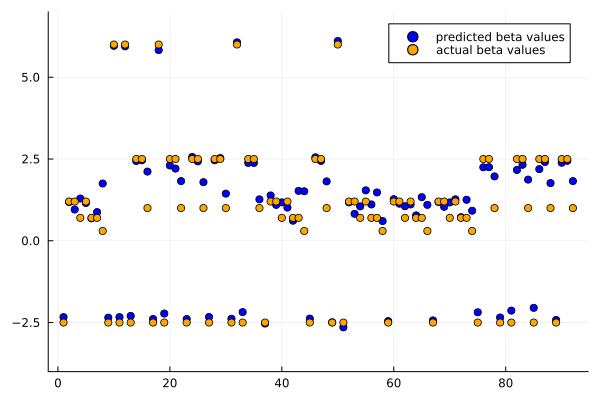

In [250]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

**Estimating Item response parameters with correct attribute profiles**

In [207]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [208]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

In [212]:
update_normal_variational_distribution(model, init_step = .01, maxiter = 1000, clip = 50.0, verbose = false, ADAMparams=optim);

In [213]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

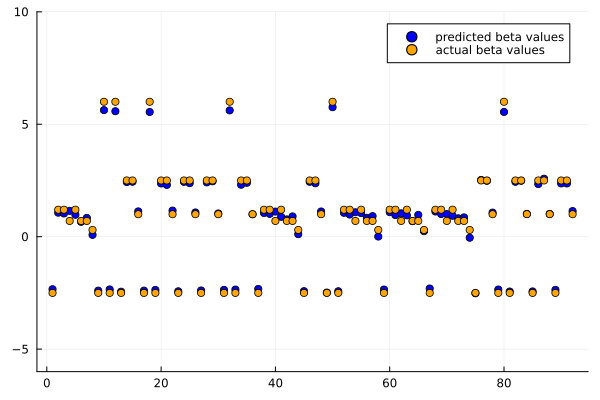

In [214]:
using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 10)

In [183]:
model.mu_beta_star

21-element Vector{Vector{Float64}}:
 [-2.152586287488463, 0.8181944245671188, 0.9420854134525904, 0.7898109636006103, 1.7707600215685275, 1.742769340015457, 1.2211185540616216, 2.4719630878936094]
 [-2.4722259783928613, 6.270633661555277]
 [-2.572758088961638, 6.368899726779423]
 [-2.785991003682104, 2.384753867735376, 2.3758758845664985, 1.751203647736447]
 [-2.5430560287975634, 6.119491718938167]
 [-2.3571668182422756, 2.628300681470573, 2.151994787049979, 2.5372873052002602]
 [-2.2307468505855597, 2.0817336952309162, 2.176190907547988, 2.3970682766573583]
 [-2.6324824259439357, 2.5705754227423165, 2.672270889779978, 0.617030083067694]
 [-2.590840516583031, 6.202317242612621]
 [-2.5065803822569204, 2.4612731373685754, 2.4732246617125666, 2.019668798283405]
 [-2.107971031762992, 0.6724201122576108, 0.27733001198629587, 0.30552323223145544, 1.6041672442032726, 2.0569095357882303, 2.38622170026355, -0.29001879306315137]
 [-2.7227691795687945, 2.642462160197521, 2.2785570074959787, 1.938

**Estimating gamma with correct attribute profiles, gamma, and tau**

In [201]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [202]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                #model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] .* 40
                #model.V_gamma_star[k][1][1][s] = randn(1, 1)^2
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    #model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] .* 40
                    # C = tril(randn(2, 2))
                    # model.V_gamma_star[k][t][z + 1][s] = C * C'
                end
            end
        end
    end
end

# Fix true values of omega and make tau small
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 100
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./ 100
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [203]:
update_normal_variational_distribution2(model, init_step = .01, maxiter = 1000, clip=50.0, verbose = false, ADAMparams=optim);

In [204]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

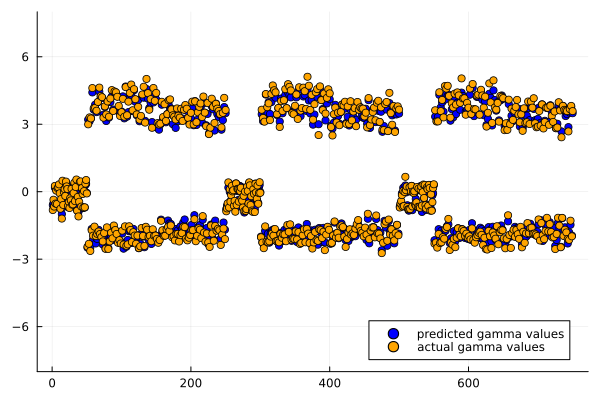

In [205]:
using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

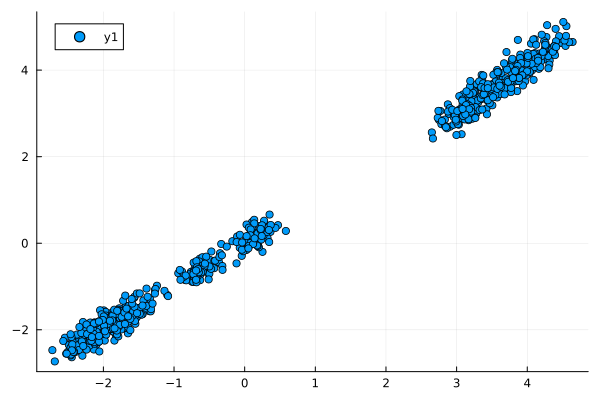

In [94]:
plot(pred_gamma_values, actual_gamma_values, seriestype=:scatter)

**Estimating omega with correct gamma**

In [115]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [117]:
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                # model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                # model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] .* 40
                model.a_tau_star[k][t][1][feature] = 50
                model.b_tau_star[k][t][1][feature] = 2
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    # model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    # model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] .* 40
                    model.a_tau_star[k][t][z + 1][feature] = 50
                    model.b_tau_star[k][t][z + 1][feature] = 2
                end
            end
        end
    end
end

# Fix true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s] ./ 100
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s] ./ 100
                end
            end
        end
    end
end


# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:2
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample tau
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [130]:
update_normal_variational_distribution3(model, init_step = 1e-3, maxiter = 5000, clip = 15.0, verbose = false, ADAMparams=optim)

In [131]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

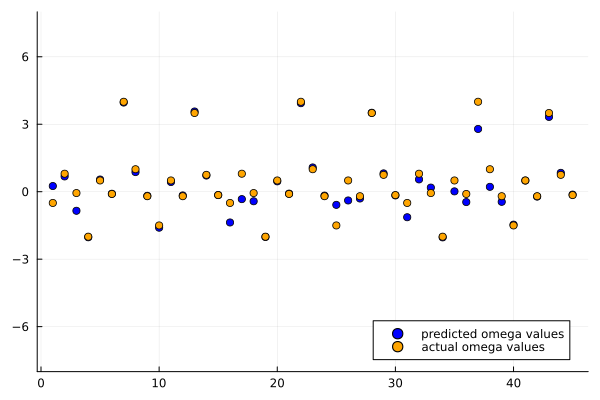

In [132]:
using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

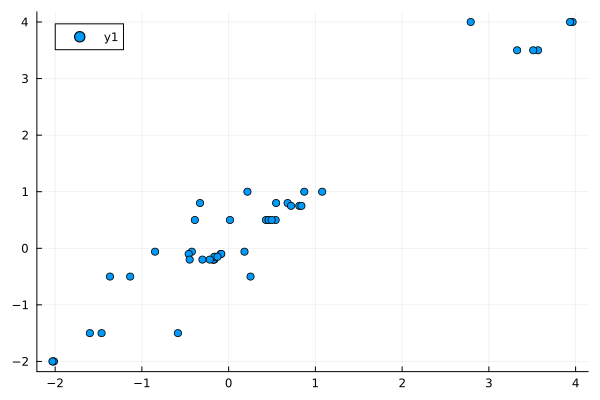

In [133]:
plot(pred_omega_values, actual_omega_values, seriestype=:scatter)

**Estimate Attribute profile, Gamma, and Omega simultaneously**

In [154]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [155]:
# profile_to_ind = Dict([0, 0]=>[0.997, 0.001, 0.001, 0.001], 
#                  [0, 1]=>[0.001, 0.997, 0.001, 0.001],
#                  [1, 0]=>[0.001, 0.001, 0.997, 0.001],
#                  [1, 1]=>[0.001, 0.001, 0.001, 0.997])

profile_to_ind = Dict([0, 0, 0] => [0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], 
                 [0, 0, 1] => [0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 0] => [0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001, 0.001],
                 [0, 1, 1] => [0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001, 0.001],
                 [1, 0, 0] => [0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001, 0.001],
                 [1, 0, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001, 0.001],
                 [1, 1, 0] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993, 0.001],
                 [1, 1, 1] => [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.993])

# Fix true values of pi
for i in 1:N
    for t in 1:O
        model.pi_star[i][t] .= profile_to_ind[Vector{Int}(data[:profiles][i, :, t])]
    end
end

# Fix true value of mu_beta
for j in 1:J
    model.mu_beta_star[j] = data[:beta][j]
    model.V_beta_star[j] = model.V_beta_star[j] ./ 100
end

# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                # model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                # model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    # model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    # model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s]
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                # model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                # model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 10
                model.a_tau_star[k][t][1][feature] = 500
                model.b_tau_star[k][t][1][feature] = 20
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    # model.mu_omega_star[k][t][z][feature] .= data[:omega][k][t][z, feature, :]
                    # model.V_omega_star[k][t][z][feature] .= model.V_omega_star[k][t][z][feature] ./ 10
                    model.a_tau_star[k][t][z][feature] = 500
                    model.b_tau_star[k][t][z][feature] = 20
                end
            end
        end
    end
end

# Sample Z
for i in 1:N
    sample_Z(model, i, 1)
    sample_Z(model, i, 2)
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:2
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [169]:
for iter in 1:2000
    # update_categorical_variational_distribution(model, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 1)
    # end

    # update_categorical_variational_distribution2(model, 2, maxiter=1, verbose=false)
    # for i in 1:N
    #     sample_Z(model, i, 2)
    # end
    update_normal_variational_distribution2(model, init_step = 1e-3, maxiter = 5, clip = 15.0, verbose = false, ADAMparams=optim)

    update_normal_variational_distribution3(model, init_step = 1e-3, maxiter = 5, clip = 15.0, verbose = false, ADAMparams=optim)

    # update_inverse_gamma_distribution(model, step = 1e-6, maxiter = 30, verbose = false)
    # for k in 1:K
    #     for t in 1:O
    #         num_features = length(model.gamma_sample[k][t][1][1][1])
    #         if t == 1
    #             for feature in 1:num_features
    #                 sample_τ(model, k, t, 0, feature)
    #             end
    #         else
    #             for z in 0:1
    #                 for feature in 1:num_features
    #                     sample_τ(model, k, t, z, feature)
    #                 end
    #             end
    #         end
    #     end
    # end
end

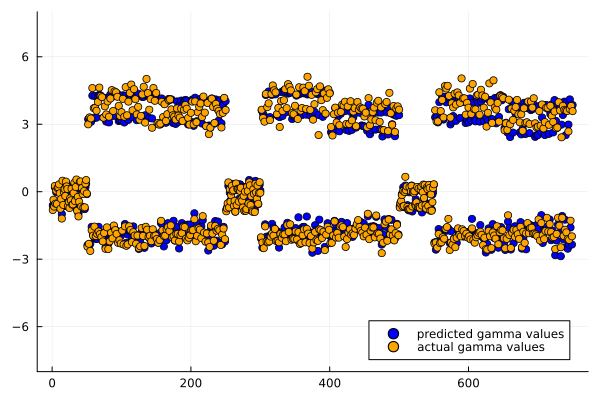

In [167]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

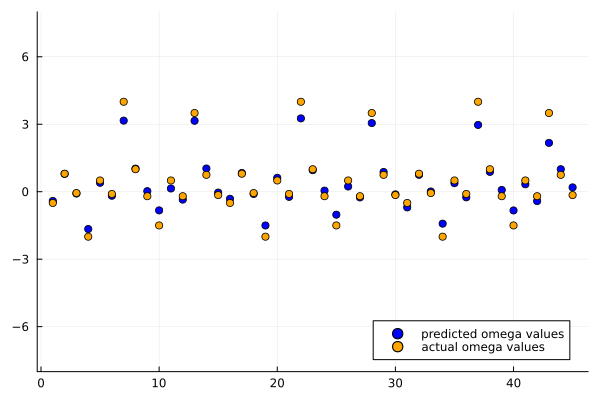

In [168]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

In [159]:
model.storage_L_par

12-element Vector{Vector{Float64}}:
 [0.6389814694285789, -0.04484969331660693, 323.2420792272924, -5.0e-324, 1.0, 1.0, 0.0, 6.953229024837e-310]
 [15.531617310360872, 44.418339000244, 54.91628727533771, 1.0e-323, 1.0e-323, 8.19670660307e-312, 1.0, 0.0]
 [23.443050976742256, 26.745436639638996, 105.26670701074903, 1.0e-323, 2.76236e-318, 1.0e-323, 1.0e-323, 0.0]
 [16.675605066619028, 1.7353344031897109, -10.559023965266533, 6.953229024837e-310, 8.19742893463e-312, 1.0e-323, 2.76236e-318, 1.0e-323]
 [83.36681612653751, 44.812781781185905, 262.19112905365864, 1.0, 120518.65099634283, 6.953229024837e-310, 8.19742893977e-312, 1.0e-323]
 [-0.9326435621326823, 4.989367023851457, -61.7243986905728, -5.0e-324, 1.0, 0.0, 2.5548126697540283, 6.953229024837e-310]
 [17.12782689250247, 21.703901495927113, 33.6016678906135, 1.0e-323, 2.76236e-318, 1.0e-323, 1.0e-323, 0.0]
 [-24.01342577350698, -5.690757343423513, -120.7943399682415, 6.953229024837e-310, 8.19791577506e-312, 1.5e-323, 2.76236e-318, 1.

In [113]:
model.mu_omega_star

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[-0.4479651888115352, 0.8030536714365704, -0.13110517555264442]]], [[[-1.4857615893584901, 0.527574322273645, -0.17167548979771713], [2.954457151519195, 0.7514116064002625, 0.009724852224643438]], [[-0.5916564692991582, 0.03680264949011168, -0.39806087665829254], [2.69121783374428, 1.0239082235396473, 0.06691431824805338]]]]
 [[[[-0.3289215755032636, 0.8086815755967179, -0.07718629595734962]]], [[[-1.5653551069806226, 0.6948058641602792, -0.34553132972242606], [3.324907841927785, 0.7486868283543374, -0.020109449712367042]], [[-0.9190349673516667, 0.141530825828378, -0.18705073128853866], [2.89720108508264, 1.1110256009381914, -0.1541043508020843]]]]
 [[[[-0.6731227875132875, 0.7992415955233616, 0.016059441120406266]]], [[[-1.0951057862687767, 0.2863559545886764, -0.3186935930016411], [2.5251668682536486, 0.9436534668063278, 0.17267118510939589]], [[-1.4817630706287825e69, -7.291817132667504e68, -6.05164274667534e69], [2.222

In [89]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[0.04380632805708367, 0.03754617516716123, 0.041198502964542055, 0.03358094980016721, 0.042444471940306726, 0.034583857021282, 0.045481489098869066, 0.04086781602938361, 0.02709358940281516, 0.04229896908992582  …  0.03401376444525767, 0.051322608525909044, 0.041872299872422955, 0.04119088759515207, 0.03998859943401588, 0.03698749321898315, 0.039663121821210824, 0.035713683047907306, 0.04691291706530896, 0.03857491464323799]]], [[[0.04601984115109581, 0.030502319910462795, 0.0339593107821378, 0.04004008464926634, 0.033753970087939816, 0.04353715730503797, 0.03869425417310628, 0.040945380512730375, 0.045056179230167054, 0.05867411458651921  …  0.05482556502266734, 0.04017656074908584, 0.0385850921129546, 0.03756093853661679, 0.03065596955960358, 0.040732209255017665, 0.04125051010959004, 0.048809264014689796, 0.04280096030402075, 0.04571557923811385], [0.03509126544779638, 0.03802095934618525, 0.042444449763167136, 0.0326323

**Estimating Tau with true value of omega and gamma**

In [268]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [269]:
# initialize true values of gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                model.mu_gamma_star[k][1][1][s] .= data[:gamma][k][1][s]
                model.V_gamma_star[k][1][1][s] .= model.V_gamma_star[k][1][1][s] ./1000
            end
        else
            for z in 0:1
                for s in 1:S
                    model.mu_gamma_star[k][t][z + 1][s] .= data[:gamma][k][t][z + 1, s, :]
                    model.V_gamma_star[k][t][z + 1][s] .= model.V_gamma_star[k][t][z + 1][s] ./1000
                end
            end
        end
    end
end

# initialize true values of omega
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                model.mu_omega_star[k][t][1][feature] .= data[:omega][k][t]
                model.V_omega_star[k][t][1][feature] .= model.V_omega_star[k][t][1][feature] ./ 1000
                #model.a_tau_star[k][t][1][feature] = 10
                #model.b_tau_star[k][t][1][feature] = .01
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    model.mu_omega_star[k][t][z + 1][feature] .= data[:omega][k][t][z + 1, feature, :]
                    model.V_omega_star[k][t][z + 1][feature] .= model.V_omega_star[k][t][z + 1][feature] ./1000
                    #model.a_tau_star[k][t][z + 1][feature] = 10
                    #model.b_tau_star[k][t][z + 1][feature] = .01
                end
            end
        end
    end
end

# # Initialize true values of tau
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = S/2
#                 model.b_tau_star[k][t][1][feature] = (S/2 - 1) * .04
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = S/2
#                     model.b_tau_star[k][t][z + 1][feature] = (S/2 - 1) * .04
#                 end
#             end
#         end
#     end
# end

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:2
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end



In [270]:
# for iter in 1:100
#     update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 30, verbose = true)
#     for k in 1:K
#         for t in 1:O
#             num_features = length(model.gamma_sample[k][t][1][1][1])
#             if t == 1
#                 for feature in 1:num_features
#                     sample_τ(model, k, t, 0, feature)
#                 end
#             else
#                 for z in 0:1
#                     for feature in 1:num_features
#                         sample_τ(model, k, t, z, feature)
#                     end
#                 end
#             end
#         end
#     end
# end
update_inverse_gamma_distribution(model, step = 1e-4, maxiter = 50000, verbose = false, ADAMparams=optim)

In [272]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.8653646448080263]], [[1.1440430398367023, 1.4404081995925304], [0.9932469227384007, 1.4417745995905957]]]
 [[[1.0632991428294394]], [[1.060505622679807, 2.0176602479830983], [1.036461065591901, 1.479423022755279]]]
 [[[1.4488423685530638]], [[1.3509575839078234, 1.9639291943040729], [1.6581979847888266, 1.334259086301752]]]

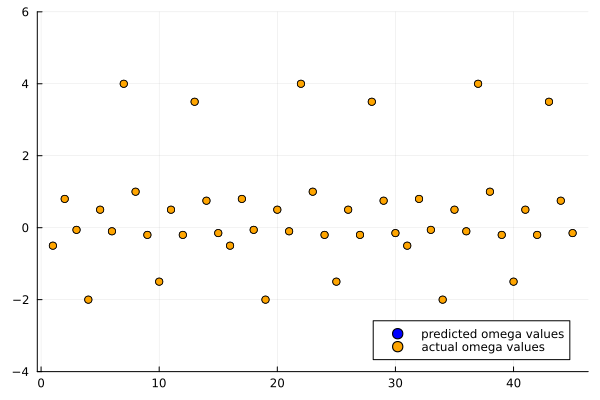

In [19]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [439]:
model.a_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [440]:
model.b_tau_prior

2-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]
 [[[1.0]], [[1.0, 1.0], [1.0, 1.0]]]

In [441]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(model.b_tau_prior[2][2][1][1] + 1/2 * est) / (25 + model.a_tau_prior[2][2][1][1] + 1)

0.0449975722238702

In [442]:
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))
end
(1/2 * est) / (25)

0.05179504733669521

In [483]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
(model.b_tau_prior[2][2][1][1] * (a - 1) + (a - 1)/2 * est) / (model.a_tau_prior[2][2][1][1] + 1 + S/2)

0.4798817361766747

In [484]:
a = S/2
est = 0
for s in 1:50
    est += (model.mu_gamma_star[2][2][1][s][1] - dot(model.obs.U[2][2][s, :], model.mu_omega_star[2][2][1][1]))^2
end
((a - 1)/2 * est) / (S/2)

0.018958741800416245

In [6]:
using Distributions
rand(InverseGamma(25, 1.5), 10)

10-element Vector{Float64}:
 0.0521556581728519
 0.06095361390366277
 0.05707761099892826
 0.059766856857519195
 0.07285482259203309
 0.06442746251797457
 0.05635128632373328
 0.07800431073247746
 0.06669058997786136
 0.05177972926478675

**Estimating full TDCM model**

In [8]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true);
optim = ADAMparams(model);

TDCModel constructed for computation on 16 threads


In [9]:
# Initialize tau distribution
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 50
#                 model.b_tau_star[k][t][1][feature] = 2
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 50
#                     model.b_tau_star[k][t][z + 1][feature] = 2
#                 end
#             end
#         end
#     end
# end

In [10]:
# Initialize small tau values
# for k in 1:K
#     for t in 1:O
#         num_features = length(model.gamma_sample[k][t][1][1][1])
#         if t == 1
#             for feature in 1:num_features
#                 model.a_tau_star[k][t][1][feature] = 3
#                 model.b_tau_star[k][t][1][feature] = 3
#             end
#         else
#             for z in 0:1
#                 for feature in 1:num_features
#                     model.a_tau_star[k][t][z + 1][feature] = 3
#                     model.b_tau_star[k][t][z + 1][feature] = 3
#                 end
#             end
#         end
#     end
# end

# Initialize random gamma
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                #model.mu_gamma_star[k][1][1][s] .= 2.0
                model.V_gamma_star[k][1][1][s] = model.V_gamma_star[k][1][1][s]
            end
        else
            for z in 0:1
                for s in 1:S
                    #model.mu_gamma_star[k][t][z + 1][s] .= 2.0
                    model.V_gamma_star[k][t][z + 1][s] = model.V_gamma_star[k][t][z + 1][s]
                end
            end
        end
    end
end

# Initialize attribute profiles as no masteries
# for i in 1:N
#     for t in 1:O
#         model.pi_star[i][t] .= [0.4, 0.2, 0.2, 0.2]
#     end
# end

#Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = ones(length(data[:beta][j]))
    model.mu_beta_star[j][1] = -1
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:2
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:2
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [11]:
for iter in 1:300
    update_categorical_variational_distribution(model, 1, step=.003, maxiter=5, verbose=false)
    update_categorical_variational_distribution(model, 2, step=.003, maxiter=5, verbose=false)
    update_normal_variational_distribution(model, init_step = .003, maxiter = 5, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution2(model, init_step = .003, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution3(model, init_step = .003, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_inverse_gamma_distribution(model, step = .003, maxiter = 5, verbose = false, ADAMparams=optim)
end

In [72]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)

preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = Vector{Int}(data[:profiles][i, :, 2])
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
    # if !correct
    #     print(Vector{Int}(data[:profiles][i, 1, :]))
    #     println(model.pi_star[i][1])
    # end
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [73]:
accuracy

0.9676

In [67]:
attribute_accs

8-element Vector{Float64}:
 0.98419452887538
 0.9667774086378738
 0.7907692307692308
 0.9387755102040817
 0.9498207885304659
 0.9442508710801394
 0.9761904761904762
 0.9966465459423206

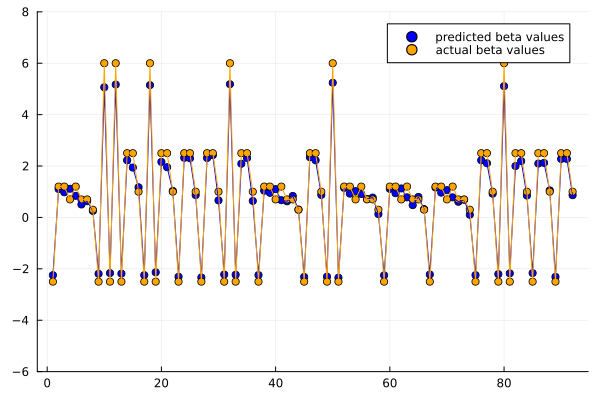

In [74]:
pred_beta_values = []
actual_beta_values = []
for j in 1:21
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data[:beta][j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
plot!(x, pred_beta_values, label = "", lc=:blue)
plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-6, 8)

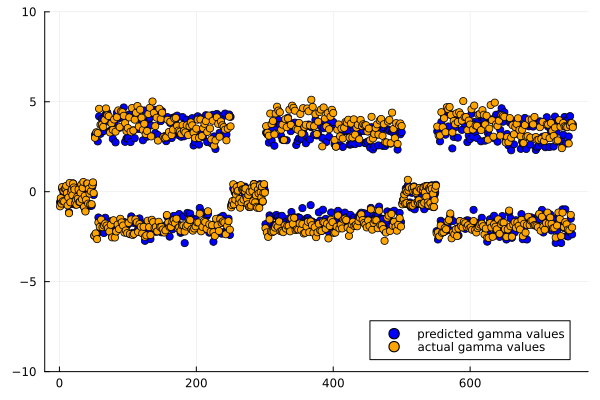

In [75]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data[:gamma][k][t][s])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:2
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data[:gamma][k][t][z, s, feature])
                    end
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-10, 10)

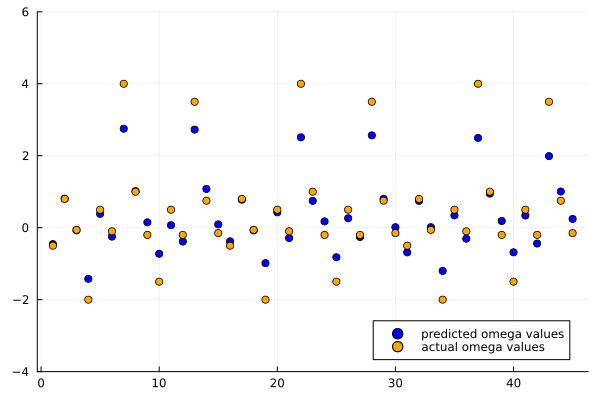

In [76]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data[:omega][k][t])
            end
        else
            for z in 0:1
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z + 1][feature])
                    actual_omega_values = vcat(actual_omega_values, data[:omega][k][t][z + 1, feature, :])
                end
            end
        end
    end
end

using Plots

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-4, 6)

In [77]:
model.a_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]
 [[[25.0]], [[25.0, 25.0], [25.0, 25.0]]]

In [78]:
model.b_tau_star

3-element Vector{Vector{Vector{Vector{Float64}}}}:
 [[[2.43714635275558]], [[2.8895699387527576, 7.137095442951641], [4.382709105589952, 6.35112408462676]]]
 [[[1.2838100579019087]], [[2.678214300157641, 5.324517640750115], [2.5097354641341956, 4.404376193562981]]]
 [[[2.0277915418941292]], [[3.7606914154736613, 6.6134078095260005], [3.051370193020698, 6.249955669189504]]]

In [47]:
model.tau_sample

3-element Vector{Vector{Vector{Vector{Vector{Float64}}}}}:
 [[[[1.4285844808681705, 1.946535501070749, 1.7633479629362043, 1.1805384517231408, 1.4659216330457, 1.7767080786808593, 2.2155067047862094, 1.7450974845801785, 1.5400923133647022, 1.551608773906616]]], [[[0.09840793752104894, 0.10208639777475488, 0.19138371997880438, 0.104880789850497, 0.1284926668163772, 0.09947891361175067, 0.08002889780013178, 0.1002256453120976, 0.17767662012106689, 0.13271376102993515], [0.2215579243978768, 0.27464635106341856, 0.18047874693420005, 0.20756590947610043, 0.23476774401072015, 0.2305690130778961, 0.13476793666300257, 0.2290856995987586, 0.18677227703840113, 0.16368571096386506]], [[0.12619028422333445, 0.13839926938468355, 0.1384689607943586, 0.119562729008115, 0.14142479187496704, 0.12503471811153738, 0.11385612301043124, 0.13229757356643118, 0.12148350247905519, 0.1681356131609271], [0.4029646706148242, 0.260836223842738, 0.19593202412938313, 0.3004024682248887, 0.3009140111990001, 0.378057

In [51]:
model.obs.X[1][1][1,:]

1-element Vector{Float64}:
 1.0